<a href="https://colab.research.google.com/github/juliuskoenning/deepsl/blob/main/DS/SignLanguageRecognitionTrainingandDetectionLogik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projektrealisierung:

**Aufgabe:**
Erstellung einer Applikation mit Kamera Input, die Zeichensprache von nicht-Hörenden / nicht-Sprechenden Personen konvertiert und diese anderen Meeting-Teilnehmern als Untertitel ausgibt. Bereitstellung eines Frontends zu Demonstrationszwecken und einer API, um die Modelle in andere Applikationen wie Teams oder Discord zu integrieren.

how to execute this notebook:
1. Go to https://drive.google.com/file/d/1be8Cai-xqnSQKJQmnVxAuEFmm_xU1N9Z/view?usp=sharing (containing the zip file with the 100 glosses), then add a shortcut to this file in your drive so that it is integrated into your google drive
2. Go to https://drive.google.com/file/d/1EIE3FUYi_hvIxAEqxaxxmrHlE1GDmcND/view?usp=sharing (containing the WASL100.json file), then add a shortcut to this file in your drive
3. Go to https://drive.google.com/drive/folders/1G7AJgMoY0OMyu64mPhJtPOBG-v5UtQSk?usp=sharing , then add a shortcut to this file in your drive
4. Run the wanted cells in the notebook
  - due to the flexible structure of the notebook there are parts to train on two different datasets (WASL & MS-ASL)
  and for different models (EfficientNet, InceptionV3)
  - to get our mentioned results we recommand to train an EfficientNet on the MS-ASL dataset --> cells 1.1, 1.2.2, 1.4, 1.5, 2.1 and 2.2 shoul be executed for this
  - otherwise just try it on your own or check the cell outputs ;)

# 1 Sign Language Detection

## 1.1 Imports

In [ ]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
!pip install -U "tensorflow>=2.10.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 44.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7933 sha256=5e45e050e68853d0518703bd1cd77fff192b90fc102c75e6ffd15e1b423ad7af
  Stored in directory: /root/.cache/pip/wheels/fc/76/04/beed1a6df4eb7430ee13c3900746edd517e5e597298d1f73f3
Successfully built remotezip
  Preparing metadata (setup.py) ... done


In [ ]:
import tqdm
import random
import shutil
import pathlib
import itertools
import collections
import math

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, \
ZeroPadding3D, ZeroPadding2D, RandomRotation, RandomCrop,RandomFlip, RandomZoom, BatchNormalization
# from tfm.vision.preprocess_ops_3d import *
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [ ]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 load dataset from drive and display one video

### 1.2.1 Dataset one

#### 1.2.1.1 Load Data from google drive

In [ ]:
! pip install kaggle
! mkdir -p ~/.kaggle/
# for the case, that kaggle.json is stored in the drive
! cp drive/MyDrive/kaggle.json ~/.kaggle/
# for the case, if kaggle.json is stored under the root dir
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'drive/MyDrive/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# download the tabacco image dataset and unzip images in the data diretory
# ! kaggle datasets download -d saurabhshahane/american-sign-language-dataset
# ! unzip -n -q american-sign-language-dataset.zip -d ms_asl

In [ ]:
shutil.unpack_archive("/content/drive/MyDrive/file.zip", "/content/data/")
#shutil.unpack_archive("/content/drive/MyDrive/MSData.zip", "/content/data_second_dataset/")

In [ ]:
DATA_DIR = "/content/data/content/WLASL/start_kit/videos/"
DATA_DIR_MSASL = "/content/data_second_dataset/content/MSData/train/"
CLASS_DIR = pathlib.Path("/content/data/classes/")

In [ ]:
print(DATA_DIR+os.listdir(DATA_DIR)[0])

/content/data/content/WLASL/start_kit/videos/07973.mp4


In [ ]:
sample_video_path = DATA_DIR+os.listdir(DATA_DIR)[0]
display.Video(sample_video_path, embed=True)

#### 1.2.1.2 load metadata

In [ ]:
import json
import pandas as pd
import shutil

LABELS_PATH = "/content/drive/MyDrive/asl100.json"

with open(LABELS_PATH) as f:
  labels_json = json.load(f)
# labels_df = pd.DataFrame(labels_dict)
# labels_df.head()
# labels_json[0]

In [ ]:
# shutil.rmtree("/content/data/classes/")

In [ ]:
if not os.path.exists("/content/data/classes/"):
  os.mkdir("/content/data/classes/")
for subset in ["train", "test", "val"]:
  if not os.path.exists(f"/content/data/classes/{subset}/"):
    os.mkdir(f"/content/data/classes/{subset}/")

In [ ]:
metadata = []
not_included_videos = []

for item in labels_json:
  for video in item["instances"]:
    if os.path.exists(f"{DATA_DIR}{video['video_id']}.mp4"):
      class_target_dir_temp = f"/content/data/classes/{video['split']}/{item['gloss']}/"
      if not os.path.exists(class_target_dir_temp):
        os.mkdir(class_target_dir_temp)
      shutil.copy(f"{DATA_DIR}{video['video_id']}.mp4", f"{class_target_dir_temp}/{video['video_id']}.mp4")
      video["gloss"] = item['gloss']
      metadata.append(video)
    else:
      not_included_videos.append(video)

In [ ]:
metadata = pd.DataFrame(metadata)
metadata.head()

bbox  frame_end  frame_start  instance_id  signer_id  \
0  [137, 16, 492, 480]         64            1            0        118   
1  [137, 16, 492, 480]         47            1            2        110   
2  [137, 16, 492, 480]         96            1            4        109   
3  [137, 16, 492, 480]       2249         2150            5        121   
4  [137, 16, 492, 480]       3852         3732            6        121   

         source  split                                           url  \
0      aslbrick  train  http://aslbricks.org/New/ASL-Videos/book.mp4   
1  valencia-asl  train   https://www.youtube.com/watch?v=0UsjUE-TXns   
2  valencia-asl  train   https://www.youtube.com/watch?v=aGtIHKEdCds   
3    northtexas    val   https://www.youtube.com/watch?v=hjS0dQDgbjo   
4    northtexas  train   https://www.youtube.com/watch?v=WGfiiDgrq1I   

   variation_id video_id gloss  
0             0    69241  book  
1             0    68011  book  
2             0    68012  book  
3             0    70212  book  
4             0    70266  book

In [ ]:
metadata["gloss"].value_counts()

book          33
clothes       21
drink         21
computer      20
chair         19
              ..
medicine      10
jacket        10
basketball    10
thursday      10
eat            9
Name: gloss, Length: 100, dtype: int64

In [ ]:
metadata["split"].value_counts()

train    948
val      229
test     134
Name: split, dtype: int64

In [ ]:
len(not_included_videos), len(metadata)

(727, 1311)

### 1.2.2 Dataset two

In [ ]:
!mkdir /content/data/

In [ ]:
shutil.unpack_archive("/content/drive/MyDrive/SignLanguagev2/TestMSData.zip", "/content/data/")
shutil.unpack_archive("/content/drive/MyDrive/SignLanguagev2/ValMSData.zip", "/content/data/")
shutil.copytree("/content/data/content/MSData/", "/content/data/", dirs_exist_ok=True)
shutil.rmtree("/content/data/content/")
for i in range(10):
  shutil.unpack_archive(f"/content/drive/MyDrive/SignLanguagev2/TrainMSData{i}.zip", "/content/data/")

In [ ]:
# setup paths for train test and validation dir
#   alternativly use uncropped videos
DATA_DIR = "/content/data/"
TEST_DIR = pathlib.Path("/content/data/test_cropped/")
TRAIN_DIR = pathlib.Path("/content/data/train_cropped/")
VAL_DIR = pathlib.Path("/content/data/val_cropped/")

In [ ]:
len(os.listdir(TEST_DIR)), len(os.listdir(TRAIN_DIR)), len(os.listdir(VAL_DIR))
missing = []
for item in os.listdir(TRAIN_DIR):
  if item not in os.listdir(TEST_DIR):
    missing.append(item)
  if item not in os.listdir(VAL_DIR):
    missing.append(item)
set(missing)

{'boring', 'thanks', 'wish', 'ﬁnish'}

In [ ]:
missing.extend(["must", "go", "but", "should"])
missing

['thanks',
 'wish',
 'wish',
 'boring',
 'ﬁnish',
 'ﬁnish',
 'must',
 'go',
 'but',
 'should']

In [ ]:
for folder in missing:
  for path in ("test", "train", "val"):
    for subpath in ("", "_cropped"):
      path_temp = DATA_DIR + path + subpath + "/" + folder
      if os.path.exists(path_temp):
        shutil.rmtree(path_temp)

In [ ]:
# count number of items in each class
def count_images_in_dataset(dataset_path, print_items: bool = False, dataset_description: str = "Training"):
  ds_class_counts = []
  ds_class_names = []
  for folder in os.listdir(dataset_path):
    class_counts = len(os.listdir(os.path.join(dataset_path, folder)))
    ds_class_counts.append(class_counts)
    ds_class_names.append(folder)
  # ds_class_counts = tf.reduce_sum(ds_class_counts, axis=0)
  # Print the number of images in each class for the current dataset optional
  if print_items:
    for counter, item in enumerate(ds_class_counts):
      # for key, value in item.items():
      print(f"{dataset_description} - Class '{ds_class_names[counter]}': {item}")
  return ds_class_counts, ds_class_names

In [ ]:
# store occurences of each class in the train, test & val datasets in a dict
dataset_number_of_occurences = {}
# for dataset, print_items, dataset_description in [[train_ds, False, "Training"], [test_ds, False, "Test"], \
#  [val_ds, False, "Validation"]]:
for dataset, print_items, dataset_description in [[TRAIN_DIR, False, "Test"]]:
    ds_class_counts, ds_class_names = count_images_in_dataset(dataset, print_items, dataset_description)

In [ ]:
import pandas as pd
df = pd.DataFrame(ds_class_counts, index=ds_class_names, columns=["Test"])
df.head()

Test
now         19
computer    15
doctor      20
walk        20
nothing     23

In [ ]:
df = df.sort_values(by="Test")
df.head()

Test
bored         8
different     9
sorry        11
big          11
chicken      11

In [ ]:
len(os.listdir(TEST_DIR)), len(os.listdir(TRAIN_DIR)), len(os.listdir(VAL_DIR))

(100, 100, 100)

In [ ]:
os.listdir(TEST_DIR)

['now',
 'computer',
 'doctor',
 'walk',
 'nothing',
 'forget',
 'no',
 'chicken',
 'please',
 'write',
 'learn',
 'paper',
 'help',
 'man',
 'name',
 'play',
 'cousin',
 'spring',
 'where',
 'hearing',
 'brown',
 'black',
 'teacher',
 'how',
 'red',
 'hello',
 'right',
 'big',
 'want',
 'fish',
 'sit',
 'tired',
 'yellow',
 'live',
 'hungry',
 'table',
 'white',
 'who',
 'like',
 'grandmother',
 'work',
 'need',
 'lost',
 'you',
 'same',
 'milk',
 'sign',
 'girl',
 'brother',
 'hurt',
 'day',
 'father',
 'sick',
 'orange',
 'boy',
 'nurse',
 'bad',
 'fine',
 'english',
 'bathroom',
 'yes',
 'dance',
 'know',
 'school',
 'what',
 'mother',
 'green',
 'when',
 'nice',
 'blue',
 'student',
 'sorry',
 'night',
 'book',
 'here',
 'understand',
 'friend',
 'draw',
 'different',
 'water',
 'again',
 'france',
 'drink',
 'sad',
 'thank you',
 'finish',
 'beautiful',
 'sister',
 'read',
 'happy',
 'bird',
 'pencil',
 'grandfather',
 'woman',
 'good',
 'family',
 'eat',
 'deaf',
 'bored',
 'pin

## 1.3 Copy MSData into the other dataset

In [ ]:
classes_dataset_one = os.listdir("/content/data/classes/train")
#TRAIN_DIR_DATASET_TWO = "/content/data_second_dataset/content/MSData/train_cropped"
#classes_dataset_two = os.listdir(TRAIN_DIR_DATASET_TWO)

print(len(classes_dataset_one))
#print(len(classes_dataset_two))

100


In [ ]:
TRAIN_DIR = pathlib.Path(os.path.join(CLASS_DIR, "train/"))
VAL_DIR = pathlib.Path(os.path.join(CLASS_DIR, "val/"))

In [ ]:
TEST_DIR = pathlib.Path(os.path.join(CLASS_DIR, "test/"))

In [ ]:
# for class_name in classes_dataset_two:
#   if class_name in classes_dataset_one:
#     shutil.copytree(f"{TRAIN_DIR_DATASET_TWO}/{class_name}", f"{TRAIN_DIR}/{class_name}", dirs_exist_ok=True)

## 1.4 preprocess video

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [ ]:
sample_video_path = "/content/data/test_cropped/again/2sGQuduhAf4.mp4"
sample_video = frames_from_video_file(sample_video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


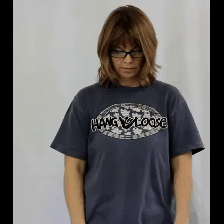

In [ ]:
to_gif(sample_video)

## 1.5 Create Dataset Generator

In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(TRAIN_DIR, 10, training=True),
                                          output_signature = output_signature)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(VAL_DIR, 10, training=False),
                                          output_signature = output_signature)


In [ ]:
test_ds = tf.data.Dataset.from_generator(FrameGenerator(TEST_DIR, 10, training=False),
                                          output_signature = output_signature)

In [ ]:
fg = FrameGenerator(TRAIN_DIR, 10, training=True)

In [ ]:
CLASS_NAMES = fg.class_names

In [ ]:
frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 79


In [ ]:
for frames, labels in train_ds.take(10): # prints the labels of 10 randomly chosen batches from the training dataset
  print(labels)

tf.Tensor(86, shape=(), dtype=int16)
tf.Tensor(29, shape=(), dtype=int16)
tf.Tensor(73, shape=(), dtype=int16)
tf.Tensor(70, shape=(), dtype=int16)
tf.Tensor(71, shape=(), dtype=int16)
tf.Tensor(68, shape=(), dtype=int16)
tf.Tensor(15, shape=(), dtype=int16)
tf.Tensor(84, shape=(), dtype=int16)
tf.Tensor(58, shape=(), dtype=int16)
tf.Tensor(41, shape=(), dtype=int16)


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)
test_ds = test_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))

print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [ ]:
test_frames, test_labels = next(iter(test_ds))

# 2 Modelltraining

## 2.1 Training setup

In [ ]:
class_num = len(fg.class_names)


# Training parameter
EPOCHS = 30
EARLY_STOPPING_PATIENCE = math.sqrt(EPOCHS)
num_classes = len(CLASS_NAMES)

# setup early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=EARLY_STOPPING_PATIENCE,
                                                  verbose=2,
                                                  restore_best_weights=True)


In [ ]:
# richtiges
# def preprocess_3d_data(data):

#     # Randomly crop the video.
#     crop_size = (10, 224, 224, 3)
#     data_shape = tf.shape(data)
#     data = tf.image.random_crop(data, size=(data_shape[0], crop_size[0], crop_size[1], crop_size[2], crop_size[3]))

#     # Add more data augmentation techniques here if needed.

#     return data

# # Create a random 3D tensor representing video data.
# video_data = tf.random.normal((10, 240, 240, 3))

# Apply the preprocessing function to the video data.
# processed_data = preprocess_3d_data(video_data)

In [ ]:
def preprocess_3d_data(data):
    # Randomly crop the video.
    crop_size = (10, 224, 224, 3)
    data_shape = tf.shape(data)
    data = tf.image.random_crop(data, size=(data_shape[0], crop_size[0], crop_size[1], crop_size[2], crop_size[3]))

    # Randomly flip the video horizontally.
    data = tf.map_fn(lambda x: tf.image.random_flip_left_right(x), data)

    # Add more data augmentation techniques here if needed.

    return data

# Create a random 3D tensor representing video data.
video_data = tf.random.normal((10, 240, 240, 3))

# # Apply the preprocessing function to the video data.
# processed_data = preprocess_3d_data(video_data)

In [ ]:
from tensorflow.keras.layers import Layer

class DataAugmentationLayer(Layer):
    def __init__(self, **kwargs):
        super(DataAugmentationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return preprocess_3d_data(inputs)

In [ ]:
from typing import Tuple
def create_preprocessing_layer(input_shape: Tuple = (10, 224, 224, 3), rescaling = True):
    video_input = tf.keras.Input(shape=input_shape)
    x = ZeroPadding3D(padding=((0, 0),(4,4),(4,4)))(video_input)
    x = DataAugmentationLayer()(x)
    if rescaling:
      x = tf.keras.layers.Rescaling(scale=255)(x)
    return video_input, x

## 2.2 EfficientNet

In [ ]:
# define the optimizer
optimizer_training = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Define model checkpoint callback
checkpoint_path = "./drive/MyDrive/training_checkpoints_efficientNet/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Save every 3 epochs
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    monitor="val_accuracy",
    save_best_only=False,
    period=3,
)

In [ ]:
def create_efficient_net_model(base_model_trainable: bool = True, rescaling: bool = True):

  net = tf.keras.applications.EfficientNetB0(include_top = False)
  net.trainable = base_model_trainable
  # Example usage:
  input_shape = (10, 224, 224, 3)
  video_input, x = create_preprocessing_layer(input_shape, rescaling = rescaling)

  x = tf.keras.layers.TimeDistributed(net)(x)
  x = tf.keras.layers.Dense(100)(x)
  x = tf.keras.layers.GlobalAveragePooling3D()(x)
  return tf.keras.Model(inputs=video_input, outputs=x)

model = create_efficient_net_model(base_model_trainable = True, rescaling = True)





16705208/16705208 [==============================] - 3s 0us/step


In [ ]:
model.compile(optimizer = optimizer_training,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [ ]:
len(CLASS_NAMES)

100

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1, callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/30
1080/1080 [==============================] - 896s 775ms/step - loss: 4.6240 - accuracy: 0.0097 - val_loss: 4.5791 - val_accuracy: 0.0230
Epoch 2/30
1080/1080 [==============================] - 818s 758ms/step - loss: 4.4268 - accuracy: 0.0324 - val_loss: 4.1943 - val_accuracy: 0.0850
Epoch 3/30
1080/1080 [==============================] - ETA: 0s - loss: 3.8625 - accuracy: 0.1162
Epoch 3: saving model to training_checkpoints_efficientNet/cp-0003.ckpt
1080/1080 [==============================] - 830s 768ms/step - loss: 3.8625 - accuracy: 0.1162 - val_loss: 3.4691 - val_accuracy: 0.1823
Epoch 4/30
1080/1080 [==============================] - 827s 766ms/step - loss: 3.1694 - accuracy: 0.2287 - val_loss: 3.1484 - val_accuracy: 0.2407
Epoch 5/30
1080/1080 [==============================] - 824s 763ms/step - loss: 2.6205 - accuracy: 0.3565 - val_loss: 2.8052 - val_accuracy: 0.3080
Epoch 6/30
1080/1080 [==============================] - ETA: 0s - loss: 2.1706 - accuracy: 0.4532
Epo

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
model.save_weights('./drive/MyDrive/checkpoints_EfficientNetB0_30epochs/my_checkpoint')

## 2.2.1 Evaluation


In [ ]:
model = create_efficient_net_model()

checkpoint_path = pathlib.Path("./drive/MyDrive/training_checkpoints_efficientNet/cp-0021.ckpt")

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds.take(1),
          epochs = 1,
          validation_data = val_ds)
model.load_weights("/content/drive/MyDrive/training_checkpoints_efficientNet/cp-0021.ckpt")

1/1 [==============================] - 218s 218s/step - loss: 4.5449 - accuracy: 0.0000e+00 - val_loss: 4.6279 - val_accuracy: 0.0106


In [ ]:
model.evaluate(test_ds)

220/220 [==============================] - 108s 490ms/step - loss: 2.5096 - accuracy: 0.5727


[2.509572982788086, 0.5727272629737854]

In [ ]:
!pip install seaborn

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def get_predictions_and_labels(dataset, model):
    pred_probs = model.predict(dataset)

    labels = []
    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy())
    labels = np.array(labels)

    return pred_probs, labels

def get_accuracy_score(labels, preds):
    return accuracy_score(labels, preds)

def top_k_accuracy(y_true, y_pred_probs, k=5):
    # Get indices of the top-k predictions
    top_k_preds = np.argsort(-y_pred_probs, axis=1)[:, :k]

    # Create a boolean array that checks if the true label is in the top-k predictions
    match_array = np.array([true_label in top_k_preds[i] for i, true_label in enumerate(y_true)])

    # Compute top-k accuracy
    top_k_acc = match_array.mean()

    return top_k_acc

def get_classification_report(labels, preds):
    return classification_report(labels, preds, zero_division=0)

def get_confusion_matrix(labels, preds):
    return confusion_matrix(labels, preds)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, cmap="YlGnBu",
                xticklabels=class_names,
                yticklabels=class_names,
                fmt='g')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
from collections import Counter

def get_most_common_labels(labels, k):
    counter = Counter(labels)
    return [item[0] for item in counter.most_common(k)]

def evaluate_model(dataset, model, class_names, top_k=5, cm_classes=10):

    # Get predicted probabilities and true labels
    pred_probs, labels = get_predictions_and_labels(dataset, model)

    # Get class indices from predicted probabilities
    preds = np.argmax(pred_probs, axis=-1)

    # Print classification report
    print("Classification Report:")
    print(get_classification_report(labels, preds))

    # Select the most common labels
    most_common_labels = get_most_common_labels(labels, cm_classes)

    # Calculate and plot a confusion matrix for the most common classes
    cm = get_confusion_matrix(labels, preds)
    cm_sub = cm[np.ix_(most_common_labels, most_common_labels)]
    plot_confusion_matrix(cm_sub, [class_names[i] for i in most_common_labels])

    # Print  accuracy score
    print("Accuracy:")
    print(get_accuracy_score(labels, preds))

    # Print  top-k accuracy
    print("Top-{} Accuracy:".format(top_k))
    print(top_k_accuracy(labels, pred_probs, k=top_k))

Evaluation on Test Dataset:
220/220 [==============================] - 116s 526ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.75      0.46         4
           1       0.00      0.00      0.00         3
           2       0.25      0.50      0.33         2
           3       1.00      0.20      0.33         5
           4       1.00      0.33      0.50         6
           5       1.00      0.50      0.67         2
           6       0.60      1.00      0.75         3
           7       0.67      0.67      0.67         3
           8       1.00      0.33      0.50         6
           9       0.00      0.00      0.00         3
          10       0.50      0.25      0.33         4
          11       1.00      1.00      1.00         4
          12       0.50      1.00      0.67         2
          13       0.33      0.50      0.40         2
          14       1.00      0.50      0.67         2
          15       1.00  

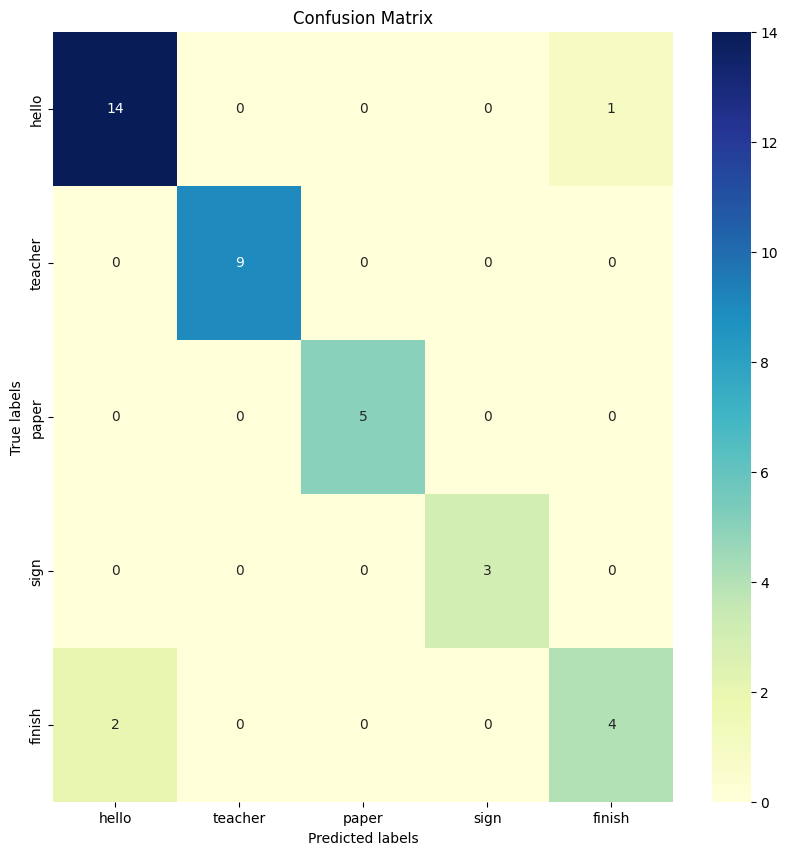

Accuracy:
0.5795454545454546
Top-10 Accuracy:
0.9136363636363637


In [ ]:
print("Evaluation on Test Dataset:")
evaluate_model(test_ds, model, fg.class_names, top_k = 10, cm_classes=5)

Evaluation on Test Dataset:
220/220 [==============================] - 138s 596ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.75      0.46         4
           1       0.00      0.00      0.00         3
           2       0.17      0.50      0.25         2
           3       1.00      0.20      0.33         5
           4       1.00      0.33      0.50         6
           5       1.00      0.50      0.67         2
           6       0.50      1.00      0.67         3
           7       1.00      0.67      0.80         3
           8       1.00      0.33      0.50         6
           9       0.00      0.00      0.00         3
          10       0.50      0.25      0.33         4
          11       1.00      1.00      1.00         4
          12       0.67      1.00      0.80         2
          13       0.33      0.50      0.40         2
          14       0.50      0.50      0.50         2
          15       1.00  

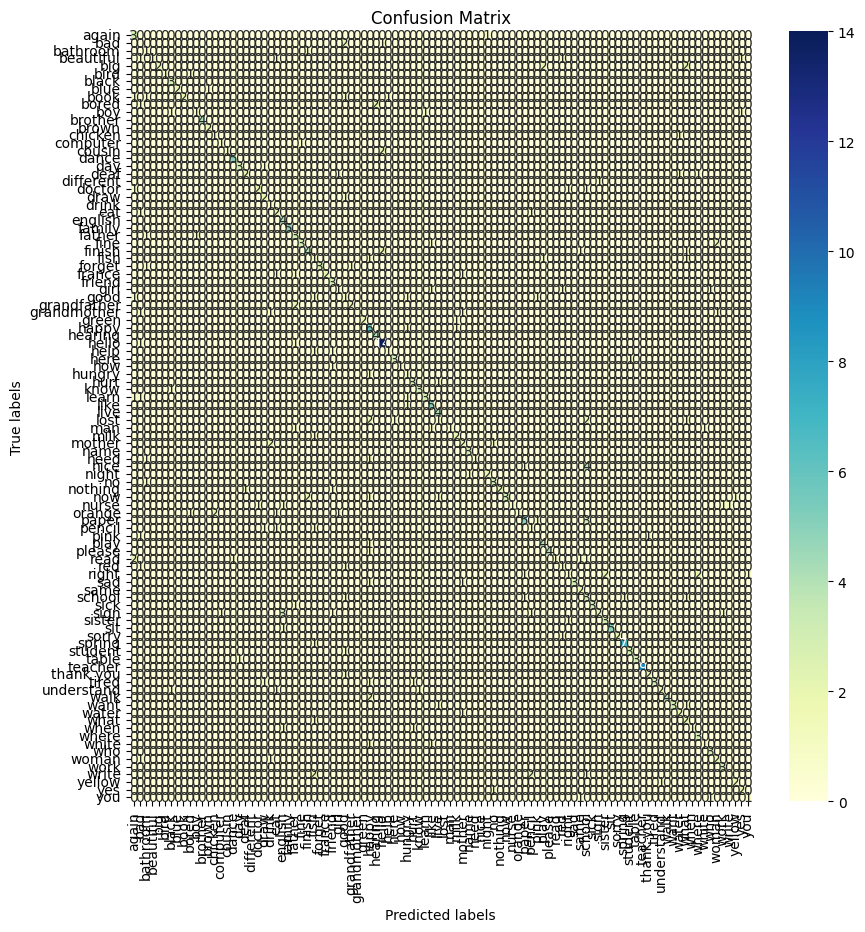

Accuracy:
0.5522727272727272
Top-5 Accuracy:
0.8363636363636363


In [ ]:
# # Evaluate on test dataset
# print("Evaluation on Test Dataset:")
# evaluate_model(test_ds, model, fg.class_names, top_k = 10)
# # evaluate_model(test_ds, model, fg.class_names, top_k=5, n_classes=10)

In [ ]:
import numpy as np
import random
from IPython.display import display, Video

# Choose dataset
dataset_choice = "test" # alternatively, use "train" or "val"
if dataset_choice == "train":
    chosen_dataset = train_ds
    dataset_path = TRAIN_DIR
elif dataset_choice == "val":
    chosen_dataset = val_ds
    dataset_path = VAL_DIR
else:
  chosen_dataset = test_ds
  dataset_path = TEST_DIR

# Create an instance of FrameGenerator for the chosen dataset
chosen_fg = FrameGenerator(dataset_path, 10)

# Select random video and true label
chosen_frames, true_label = random.choice(list(chosen_fg()))

# model prediction
chosen_frames_expanded = np.expand_dims(chosen_frames, axis=0)
predicted_label = np.argmax(model.predict(chosen_frames_expanded), axis=-1)

# Get the true label's class name
true_class_name = chosen_fg.class_names[true_label]

#get the predicted labels class name
predicted_class_name = chosen_fg.class_names[predicted_label[0]]

print(f"True label: {true_label} ({true_class_name})")
print(f"Predicted label: {predicted_label[0]} ({predicted_class_name})")

# Display the video
random_video_path = None
for path, name in zip(*chosen_fg.get_files_and_class_names()):
    if chosen_fg.class_ids_for_name[name] == true_label:
        random_video_path = str(path)
        break

if random_video_path:
    Video(random_video_path, embed=True)
else:
    print("Error: video not found.")

In [ ]:
sample_video = frames_from_video_file(random_video_path, n_frames = 10)
to_gif(sample_video)

## 2.3 Inception V3

In [ ]:
optimizer_training = tf.keras.optimizers.Adam(learning_rate=1e-4)
def create_inception_v3_model(base_model_trainable: bool = True, rescaling:bool = True):

  net = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(224, 224, 3)
  )
  net.trainable = base_model_trainable
  # Example usage:
  input_shape = (10, 224, 224, 3)
  video_input, x = create_preprocessing_layer(input_shape, rescaling = rescaling)

  x = tf.keras.layers.TimeDistributed(net)(x)
  x = tf.keras.layers.Dense(100)(x)
  x = tf.keras.layers.GlobalAveragePooling3D()(x)
  return tf.keras.Model(inputs=video_input, outputs=x)

inception_model = create_inception_v3_model(base_model_trainable = True, rescaling = True)

inception_model.compile(optimizer=optimizer_training,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

# Define model checkpoint callback
checkpoint_path = "training_checkpoints_inceptionv3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Save every 3 epochs
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    monitor="val_loss",
    save_best_only=False,
    period=3,
)

inception_model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[early_stopping, model_checkpoint_callback])

In [ ]:
# Evaluate on test dataset
print("Evaluation on Test Dataset:")
evaluate_model(test_ds, inception_model, fg.class_names)

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
inception_model.save_weights(f'./drive/MyDrive/checkpoints_inceptionv3_{EPOCHS}_epochs/my_checkpoint')

# 3 Detection

In [ ]:
! pip install moviepy
! pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 16.0 MB/s eta 0:00:00


In [ ]:
# import detection librarys
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip
from moviepy.video.fx.all import crop

mp_face_mesh = mp.solutions.face_mesh

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


def draw_landmarks(image, results):
    mp_holistic = mp.solutions.holistic  # Holistic model
    mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

    # Draw left hand connections
    image_new = mp_drawing.draw_landmarks(
        image,
        landmark_list=results.left_hand_landmarks,
        connections=mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=(232, 254, 255), thickness=1, circle_radius=4
        ),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=(255, 249, 161), thickness=2, circle_radius=2
        ),
    )

    image = image_new if image_new is not None else image
    # Draw right hand connections
    image_new = mp_drawing.draw_landmarks(
        image,
        landmark_list=results.right_hand_landmarks,
        connections=mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=(232, 254, 255), thickness=1, circle_radius=4
        ),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=(255, 249, 161), thickness=2, circle_radius=2
        ),
    )
    image = image_new if image_new is not None else image

    return image


def cut_videos(start_frame, end_frame, video_path, counter, min_x, max_x, min_y, max_y ):
    cap_temp = cv2.VideoCapture(video_path)


    output_path = video_path.split(".")[0] + str(counter) + "." + video_path.split(".")[1]

    # Get the frames per second (fps) and frame count of the video
    fps = cap_temp.get(cv2.CAP_PROP_FPS)
    frame_count = cap_temp.get(cv2.CAP_PROP_FRAME_COUNT)

    # Set the start and end frame numbers
    start_frame_num = start_frame
    end_frame_num = end_frame

    # Check if the specified frames are within the video's range
    if start_frame_num > frame_count or end_frame_num > frame_count:
        print("Invalid frame range.")
        cap_temp.release()
        exit()

    # Set the start frame position
    cap_temp.set(cv2.CAP_PROP_POS_FRAMES, start_frame_num)

    # Create a VideoWriter object to write the extracted frames
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    output = cv2.VideoWriter(output_path, fourcc, fps, (int(cap_temp.get(3)), int(cap_temp.get(4))))

    # Read and write the frames within the specified range
    current_frame = start_frame_num

    while current_frame <= end_frame_num:
        ret, frame = cap_temp.read()
        if not ret:
            break

        height, width = frame.shape[:2]
        # print(height, width)
        # cropped_frame = frame[int(min_x*width):int(max_x*width), int(min_y*height):int(max_y*height)]

        # print(cropped_frame.shape)

        output.write(frame)
        current_frame += 1

    cap_temp.release()

    return {output_path: [int(min_x*width), int(min_y*height), int(max_x*width), int(max_y*height)]}
    # cap.release()
    # clip = VideoFileClip(output_path)
    # new_clip = crop(clip, x1=int(min_x*width), y1=int(min_y*height), x2=int(max_x*width), y2=int(max_y*height))
    # target_path_cropped = output_path.split(".")[0] + "cropped." + output_path.split(".")[1]
    # print(new_clip.write_videofile(target_path_cropped, codec='mpeg4', audio=False))


def filter_min_max(lst):
    x_vals = [i.x for i in lst]
    y_vals = [i.y for i in lst]
    min_x = min(x_vals)
    max_x = max(x_vals)
    min_y = min(y_vals)
    max_y = max(y_vals)
    return [min_x, max_x, min_y, max_y]


def get_min_max_of_face(frame):
    with mp_face_mesh.FaceMesh(static_image_mode=True,
                           max_num_faces=1,
                        #    refine_landmarks=True,
                           min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(frame)

    if bool(results.multi_face_landmarks):
        face_landmarks = results.multi_face_landmarks[0]
        face_coordinates = [face_landmark for face_landmark in face_landmarks.landmark]
        return filter_min_max(face_coordinates)
    else:
        return [None, None, None, None]


def create_empty_dataframe():
    return pd.DataFrame(columns=["left_hand_x_min", "left_hand_x_max", "left_hand_y_min", "left_hand_y_max",
                                                    "right_hand_x_min", "right_hand_x_max", "right_hand_y_min", "right_hand_y_max",
                                                    "face_x_min", "face_x_max", "face_y_min", "face_y_max"])


def crop_videos_from_dataframe(df: pd.DataFrame, cap):
    # for item in ["left_hand_x_min", "left_hand_x_max", "right_hand_x_min", "right_hand_x_max"]:
    #     df[item].fillna(df["face_x_min"].dropna().max())

    # for item in ["left_hand_y_max", "left_hand_y_min", "right_hand_y_max", "right_hand_y_min"]:
    #     df[item].fillna(df["face_y_min"].dropna().max())

    # df["left_hand_x_max"].fillna(df["face_x_max"].dropna().max())
    min_x = np.nanmin(np.array((df["left_hand_x_min"].dropna().min(),df["face_x_min"].dropna().min(), df["right_hand_x_min"].dropna().min())))
    min_y = np.nanmin(np.array((df["left_hand_y_min"].dropna().min(),df["face_y_min"].dropna().min(), df["right_hand_y_min"].dropna().min())))
    max_x = np.nanmax(np.array((df["left_hand_x_max"].dropna().max(),df["face_x_max"].dropna().max(), df["right_hand_x_max"].dropna().max())))
    max_y = np.nanmax(np.array((df["left_hand_y_max"].dropna().max(),df["face_y_max"].dropna().max(), df["right_hand_y_max"].dropna().max())))
    # min_y = min(min(df["left_hand_y_min"]), min(df["face_y_min"]), min(df["right_hand_y_min"]))
    # max_x = max(max(df["left_hand_x_max"]), max(df["face_x_max"]), max(df["right_hand_x_max"]))
    # max_y = max(max(df["left_hand_y_max"]), max(df["face_y_max"]), max(df["right_hand_y_max"]))
    face_middle = (df["face_x_min"].dropna().mean() + df["face_x_max"].dropna().mean())/2
    distance = max(face_middle-min_x, max_x-face_middle)
    # crop_video(face_middle-distance, min_y, face_middle+distance, max_y)
    min_x = face_middle-distance-0.1 if face_middle-distance-0.1 > 0 else 0
    max_x = face_middle+distance+0.1  if face_middle+distance+0.1 < 1 else 1
    min_y = min_y-0.1 if min_y-0.1 > 0 else 0
    max_y = max_y+0.1 if max_y+0.1 < 1 else 1
    print(face_middle-distance, face_middle+distance, min_y, max_y)
    return face_middle-distance, face_middle+distance, min_y, max_y

In [ ]:
video_path = "/content/africa_basketball_sleep.mp4"

cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)

threshold_counter_no_hand = fps // 2

video_times = []
crop_video = []
video_postions = create_empty_dataframe()
start_time_temp = None
counter_no_hand = None
# end_time_temp = None
frame_counter = 0

# Check if camera opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")

with mp.solutions.holistic.Holistic(
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    ) as holistic:
  # Read until video is completed
  while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      frame_counter += 1

      # Make detections
      image, results = mediapipe_detection(frame, holistic)
      if results is not None:
        if results.left_hand_landmarks is not None:
          video_postions_temp = filter_min_max([hand_landmarks for hand_landmarks in results.left_hand_landmarks.landmark])
        else:
          video_postions_temp = [None, None, None, None]
        if results.right_hand_landmarks is not None:
          video_postions_temp.extend(filter_min_max([hand_landmarks for hand_landmarks in results.right_hand_landmarks.landmark]))
        else:
          video_postions_temp.extend([None, None, None, None])

        video_postions_temp.extend(get_min_max_of_face(frame))
        video_postions_temp_df = pd.DataFrame([video_postions_temp],
                                           columns=["left_hand_x_min", "left_hand_x_max", "left_hand_y_min", "left_hand_y_max",
                                                    "right_hand_x_min", "right_hand_x_max", "right_hand_y_min", "right_hand_y_max",
                                                    "face_x_min", "face_x_max", "face_y_min", "face_y_max"])
        video_postions = pd.concat([video_postions, video_postions_temp_df], ignore_index=True)

      if results.right_hand_landmarks is None and results.left_hand_landmarks is None:

        if counter_no_hand is not None:
          counter_no_hand += 1

          if counter_no_hand > threshold_counter_no_hand:
            # if end_time_temp is None:
            if (frame_counter - start_time_temp) > fps:
              video_times.append((start_time_temp, frame_counter))
              min_x, max_x, min_y, max_y = crop_videos_from_dataframe(video_postions, cap)
              video_postions = create_empty_dataframe()
              crop_video.append(cut_videos(start_time_temp, frame_counter, video_path, len(video_times), min_x, max_x, min_y, max_y))
              start_time_temp = None
              counter_no_hand = None

      else:
        if start_time_temp is None:
          start_time_temp = frame_counter
          counter_no_hand = 0

      if results is not None and image is not None:
        image = draw_landmarks(image, results)

      # # Display the resulting frame
      # cv2.imshow('Image', image)


      # # Press Q on keyboard to  exit
      # if cv2.waitKey(25) & 0xFF == ord('q'):
      #   break

    # Break the loop
    else:
      break

if start_time_temp is not None:
  if (frame_counter - start_time_temp) > fps:
    video_times.append((start_time_temp, frame_counter))
    min_x, max_x, min_y, max_y = crop_videos_from_dataframe(video_postions, cap)
    video_postions = create_empty_dataframe()
    crop_video.append(cut_videos(start_time_temp, frame_counter, video_path, len(video_times), min_x, max_x, min_y, max_y))

# When everything done, release the video capture object
cap.release()

for item in crop_video:
    for key, value in item.items():
        clip = VideoFileClip(key)
        new_clip = crop(clip, x1=value[0], y1=value[1], x2=value[2], y2=value[3])
        target_path_cropped = key.split(".")[0] + "cropped." + key.split(".")[1]
        print(new_clip.write_videofile(target_path_cropped, audio=False))   # , codec='mpeg4'

0.14124059677124023 0.7943491628489544 0.25824429988861086 1
0.15439002215862274 0.7507070012465873 0.3042009711265564 1
0.15970732271671295 0.6148082461238893 0.3082416892051697 1
Moviepy - Building video /content/africa_basketball_sleep1cropped.mp4.
Moviepy - Writing video /content/africa_basketball_sleep1cropped.mp4



t:  98%|█████████▊| 41/42 [00:00<00:00, 75.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/africa_basketball_sleep1.mp4, 2035584 bytes wanted but 0 bytes read,at frame 41/42, at time 1.37/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/africa_basketball_sleep1cropped.mp4
None
Moviepy - Building video /content/africa_basketball_sleep2cropped.mp4.
Moviepy - Writing video /content/africa_basketball_sleep2cropped.mp4



t:  94%|█████████▍| 62/66 [00:01<00:00, 40.26it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/africa_basketball_sleep2.mp4, 2035584 bytes wanted but 0 bytes read,at frame 65/66, at time 2.17/2.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/africa_basketball_sleep2cropped.mp4
None
Moviepy - Building video /content/africa_basketball_sleep3cropped.mp4.
Moviepy - Writing video /content/africa_basketball_sleep3cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/africa_basketball_sleep3cropped.mp4
None


In [ ]:
model = create_efficient_net_model()

checkpoint_path = pathlib.Path("/content/drive/MyDrive/checkpoints_EfficientNetB0_15epochs")

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds.take(1),
          epochs = 1,
          validation_data = val_ds)

1/1 [==============================] - 107s 107s/step - loss: 4.7126 - accuracy: 0.0000e+00 - val_loss: 4.6357 - val_accuracy: 0.0000e+00


In [ ]:
# Loads the weights
model.load_weights("/content/drive/MyDrive/checkpoints_EfficientNetB0_15epochs/my_checkpoint")

1/1 [==============================] - 0s 59ms/step
Predicted label: 40 (finish)



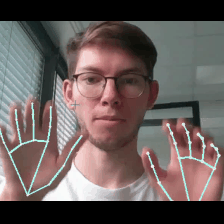

In [ ]:
from IPython.display import display

# setup test dataset path
dataset_path = pathlib.Path("/content/test_folders")

# Create an instance of FrameGenerator for the chosen dataset
chosen_fg = FrameGenerator(dataset_path, 10)

# Select random video and true label
chosen_frames, true_label = random.choice(list(chosen_fg()))

# model prediction
chosen_frames_expanded = np.expand_dims(chosen_frames, axis=0)
predicted_label = np.argmax(model.predict(chosen_frames_expanded), axis=-1)

# Get the true label's class name
true_class_name = chosen_fg.class_names[true_label]

#get the predicted labels class name
predicted_class_name = CLASS_NAMES[predicted_label[0]]

# print(f"True label: {true_label} ({true_class_name})")
print(f"Predicted label: {predicted_label[0]} ({predicted_class_name})")

# Display the video
random_video_path = None
for path, name in zip(*chosen_fg.get_files_and_class_names()):
    if chosen_fg.class_ids_for_name[name] == true_label:
        random_video_path = str(path)
        break

# if random_video_path:
#     display(Video(to_gif(sample_video), embed=True))
# else:
#     print("Error: video not found.")
sample_video = frames_from_video_file(random_video_path, n_frames = 10)
to_gif(sample_video)

In [ ]:
display(Video("/content/africa_basketball_sleep.mp4", embed=True))

In [ ]:
random_video_path

'/content/test_folders/test/africa_basketball_sleep1.mp4'